In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Bidirectional

In [4]:
mpl.rcParams['figure.figsize'] = (10, 6)

In [5]:
lookback = 50

# **Data Loading**

In [6]:
ticker = 'AAPL'
start_time = '2012-01-01'
end_time = '2023-12-31'

In [7]:
df = pd.DataFrame()
df = yf.download(ticker, start=start_time, end=end_time, progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433824,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639428,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771558,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400


In [8]:
new_df = df['Close']
new_df

Date
2012-01-03     14.686786
2012-01-04     14.765714
2012-01-05     14.929643
2012-01-06     15.085714
2012-01-09     15.061786
                 ...    
2023-12-22    193.600006
2023-12-26    193.050003
2023-12-27    193.149994
2023-12-28    193.580002
2023-12-29    192.529999
Name: Close, Length: 3018, dtype: float64

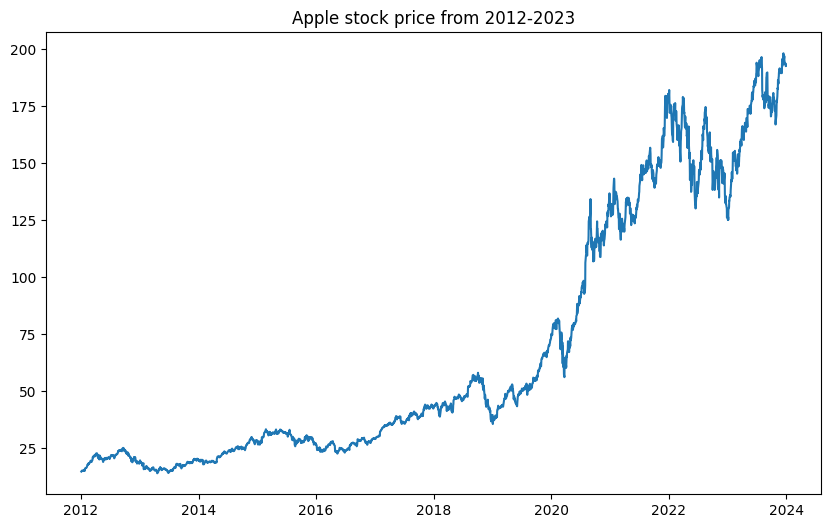

In [9]:
plt.title('Apple stock price from 2012-2023')
plt.plot(new_df)

plt.show()

# **Data Preparation**

In [10]:
def train_test_split(lookback):
  train = new_df.iloc[:2768]
  test = new_df.iloc[2768:]

  train = train.values.reshape(-1, 1)
  test = test.values.reshape(-1, 1)

  #########################

  scaler_train = MinMaxScaler()
  train = scaler_train.fit_transform(train)

  X_train = []
  Y_train = []

  for i in range(lookback, len(train)):
    X_train.append(train[i - lookback:i, 0])
    Y_train.append(train[i, 0])

  X_train = np.array(X_train)
  Y_train = np.array(Y_train)

  #########################

  scaler_test = MinMaxScaler()
  test = scaler_test.fit_transform(test)

  X_test = []
  Y_test = []

  for i in range(lookback, len(test)):
    X_test.append(test[i - lookback:i, 0])
    Y_test.append(test[i, 0])

  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return X_train, Y_train, X_test, Y_test, scaler_test.scale_[0]

In [11]:
X_train, Y_train, X_test, Y_test, scale = train_test_split(lookback)

# **Prediction using Bi-Directional LSTM**

## **Bi-Directional LSTM**

In [12]:
def BI_LSTM_model():
  model = Sequential()

  model.add(Bidirectional(LSTM(units=50, activation= 'tanh', return_sequences=True)))
  model.add(Dropout(0.2))

  model.add(Bidirectional(LSTM(units=50, activation= 'tanh', return_sequences=True)))
  model.add(Dropout(0.2))

  model.add(Bidirectional(LSTM(units=100, activation= 'tanh')))
  model.add(Dropout(0.2))

  model.add(Dense(units=1))

  return model

In [13]:
bi_lstm = BI_LSTM_model()
bi_lstm.build((lookback, lookback, 1))
bi_lstm.compile(optimizer=Adam(learning_rate=0.01),
                loss='mean_squared_error')
bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (50, 50, 100)             20800     
 al)                                                             
                                                                 
 dropout (Dropout)           (50, 50, 100)             0         
                                                                 
 bidirectional_1 (Bidirecti  (50, 50, 100)             60400     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (50, 50, 100)             0         
                                                                 
 bidirectional_2 (Bidirecti  (50, 200)                 160800    
 onal)                                                           
                                                        

## **Model Training**

In [14]:
batch_size = 32
epochs=100

history = bi_lstm.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, Y_test),
                      verbose=1)

Epoch 1/100
85/85 [==============================] - 35s 52ms/step - loss: 0.0221 - val_loss: 0.0186
Epoch 2/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 3/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 4/100
85/85 [==============================] - 2s 26ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 5/100
85/85 [==============================] - 3s 32ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 6/100
85/85 [==============================] - 2s 24ms/step - loss: 9.4441e-04 - val_loss: 0.0038
Epoch 7/100
85/85 [==============================] - 2s 24ms/step - loss: 9.4320e-04 - val_loss: 0.0038
Epoch 8/100
85/85 [==============================] - 2s 24ms/step - loss: 8.7144e-04 - val_loss: 0.0035
Epoch 9/100
85/85 [==============================] - 2s 24ms/step - loss: 8.3967e-04 - val_loss: 0.0054
Epoch 10/100
85/85 [==============================] - 2s 28ms/step - loss: 8.7421e-

# **Prediction**

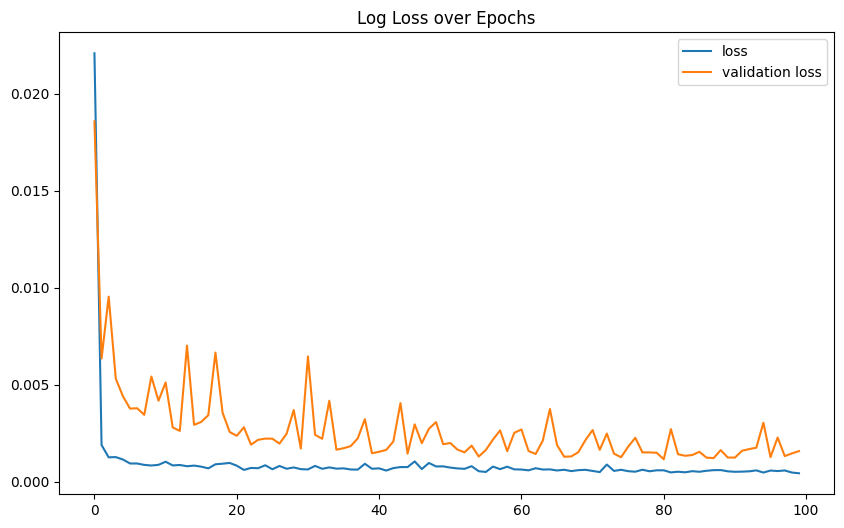

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title('Log Loss over Epochs')

plt.legend()
plt.show()

In [16]:
Y_test_pred = bi_lstm.predict(X_test, verbose=0)

Y_test = Y_test/scale
Y_test_pred = Y_test_pred/scale

In [17]:
r2_score_test = r2_score(Y_test, Y_test_pred)
print("R2 score for test data = ", np.round(r2_score_test, 5))

R2 score for test data =  0.92619


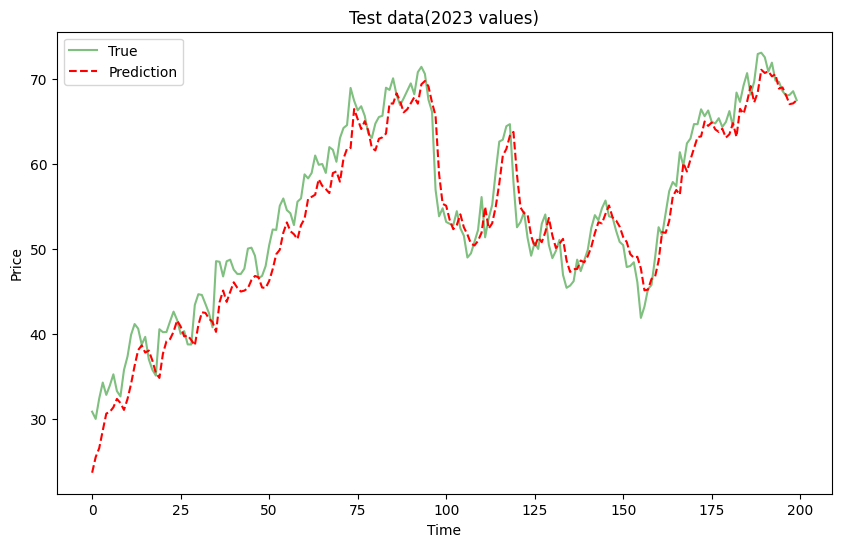

In [18]:
plt.plot(Y_test, alpha=0.5, color='g', label='True')
plt.plot(Y_test_pred, color='r', ls='dashed', label='Prediction')

plt.title('Test data(2023 values)');
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()
plt.show()